# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

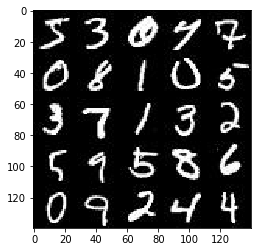

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

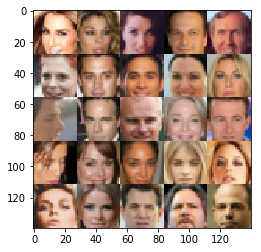

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/dhanoopkarunakaran/anaconda/envs/dlndp5/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_image = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")

    return input_image, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x = images
        #x = tf.image.resize_images(x, (32,32))
        
        #input: 28*28*3 output: 14*14*64
        x1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='same')
        #leaky RELU
        x1 = tf.maximum(x1*alpha, x1)
        
        #input: 14*14*64 output: 7*7*128
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        #leaky RELU
        x2 = tf.maximum(x2*alpha, x2)
        
        #input: 7*7*128 output: 4*4*256
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        #leaky RELU
        x3 = tf.maximum(x3*alpha, x3)
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        #output: 2x2x512
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        #input: 2x2x512 #output: 7x7x256
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        #input: 7x7x256 #output: 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real_out, d_model_real_logits = discriminator(input_real, reuse=False)
    d_model_fake_out, d_model_fake_logits = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real_logits, labels=tf.ones_like(d_model_real_out)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits, labels=tf.zeros_like(d_model_fake_out)))
    d_loss = d_loss_real+d_loss_fake
    
    g_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits, labels=tf.ones_like(d_model_fake_out)))

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    operations = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update = [opt for opt in operations if opt.name.startswith('generator')]
    with tf.control_dependencies(g_update):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    show_output = 100
    no_images = 25
    count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                count +=1
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                # At the end of each epoch, get the losses and print them out
                #train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                #train_loss_g = sess.run(g_loss, {input_z: batch_z})
                
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                losses.append((train_loss_d, train_loss_g))
                if count == show_output:
                    show_generator_output(sess, no_images, input_z, image_channels, data_image_mode)
                    count = 0
            print("Output after epoch: {}".format(epoch_i+1))
            show_generator_output(sess, no_images, input_z, image_channels, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 29.9396... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 2.5876... Generator Loss: 0.0924
Epoch 1/2... Discriminator Loss: 10.7467... Generator Loss: 20.6127
Epoch 1/2... Discriminator Loss: 2.1144... Generator Loss: 3.5709
Epoch 1/2... Discriminator Loss: 6.3793... Generator Loss: 0.0018
Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 6.0267
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 1.5853
Epoch 1/2... Discriminator Loss: 7.7061... Generator Loss: 0.0026
Epoch 1/2... Discriminator Loss: 1.4867... Generator Loss: 4.8189
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.4764... Generator Loss: 1.3686
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.6600... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 2.1478
Epoch 1/2... Discriminator Loss: 2.1263... Generator Loss: 0.6261
Epoch 1

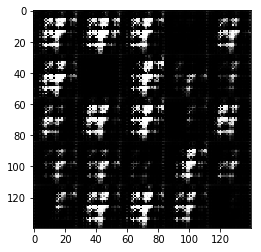

Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 2.6991
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 2.6727
Epoch 1/2... Discriminator Loss: 0.5548... Generator Loss: 1.7058
Epoch 1/2... Discriminator Loss: 0.4902... Generator Loss: 2.4235
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 1.9157
Epoch 1/2... Discriminator Loss: 0.2709... Generator Loss: 2.2266
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 2.7213
Epoch 1/2... Discriminator Loss: 0.3383... Generator Loss: 1.9899
Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 3.0711
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 14.1688
Epoch 1/2... Discriminator Loss: 0.0146... Generator Loss: 9.7904
Epoch 1/2... Discriminator Loss: 0.0163... Generator Loss: 5.8434
Epoch 1/2... Discriminator Loss: 0.0754... Generator Loss: 3.3268
Epoch 1/2... Discriminator Loss: 0.1476... Generator Loss: 2.3306
Epoch 1/2

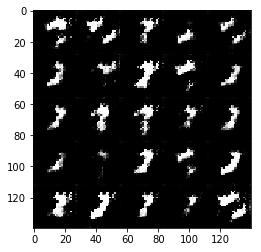

Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.6094
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 4.2418
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 0.3241... Generator Loss: 4.8486
Epoch 1/2... Discriminator Loss: 0.2046... Generator Loss: 2.3587
Epoch 1/2... Discriminator Loss: 0.3162... Generator Loss: 1.6766
Epoch 1/2... Discriminator Loss: 0.1644... Generator Loss: 4.5115
Epoch 1/2... Discriminator Loss: 0.1067... Generator Loss: 4.5971
Epoch 1/2... Discriminator Loss: 0.1487... Generator Loss: 2.7725
Epoch 1/2... Discriminator Loss: 0.3611... Generator Loss: 1.7615
Epoch 1/2... Discriminator Loss: 0.2001... Generator Loss: 4.7020
Epoch 1/2... Discriminator Loss: 0.2235... Generator Loss: 2.5880
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 2.0977... Generator Loss: 9.8482
Epoch 1/2... Discriminator Loss: 0.0813... Generator Loss: 4.5467
Epoch 1/2.

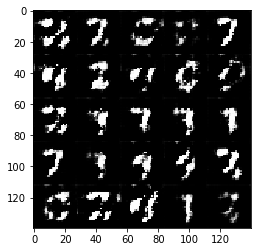

Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 1.6165
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 5.6754
Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 1.7797
Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 1.8191
Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 3.0464
Epoch 1/2... Discriminator Loss: 0.3628... Generator Loss: 2.9399
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 1.6695
Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 2.3651
Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 1.9280
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 1.0386
Epoch 1/2... Discriminator Loss: 1.9654... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 2.0567... Generator Loss: 4.4950
Epoch 1/2... Discriminator Loss: 1.7392... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.6049
Epoch 1/2.

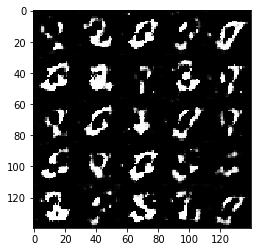

Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 4.5077
Epoch 1/2... Discriminator Loss: 0.3364... Generator Loss: 3.2252
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 3.4577
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.3018
Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 2.1305
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 2.9902
Epoch 1/2... Discriminator Loss: 1.8533... Generator Loss: 0.3491
Epoch 1/2... Discriminator Loss: 1.6619... Generator Loss: 6.3422
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 2.4473
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 3.8910
Epoch 1/2.

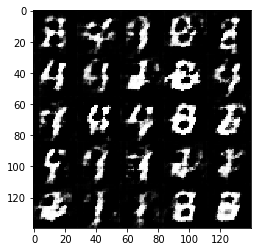

Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.4915
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 1.7977
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 2.2979
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 2.1010
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.6318
Epoch 1/2... Discriminator Loss: 0.4965... Generator Loss: 1.9929
Epoch 1/2... Discriminator Loss: 0.5077... Generator Loss: 1.6013
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.7116
Epoch 1/2... Discriminator Loss: 0.6877... Generator Loss: 2.4002
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 2.6465
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 1.6412... Generator Loss: 4.6871
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.7316
Epoch 1/2.

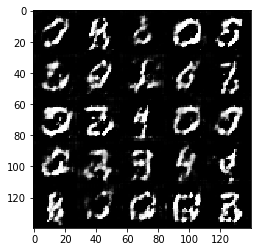

Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 2.8265
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 1.9274
Epoch 1/2... Discriminator Loss: 0.5293... Generator Loss: 1.5256
Epoch 1/2... Discriminator Loss: 0.4582... Generator Loss: 2.0891
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.1798
Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 1.8552
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 3.7162
Epoch 1/2... Discriminator Loss: 1.8754... Generator Loss: 0.3802
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 3.1278
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 0.9164
Epoch 1/2.

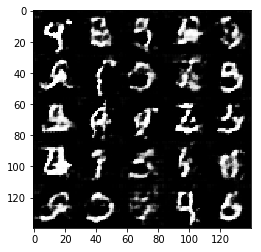

Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.1549
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 2.2179
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.4764
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 2.8982
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 0.6469... Generator Loss: 2.8644
Epoch 1/2... Discriminator Loss: 1.5882... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 2.7718
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.5419
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.8384
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 2.1929
Epoch 1/2... Discriminator Loss: 1.6049... Generator Loss: 0.4261
Epoch 1/2.

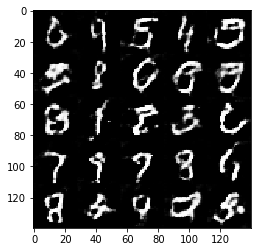

Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 1.2201
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.4882
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 2.6581
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 1.0469
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 1.9974
Epoch 1/2... Discriminator Loss: 1.5927... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 4.0051
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.4750
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 0.7686
Epoch 1/2.

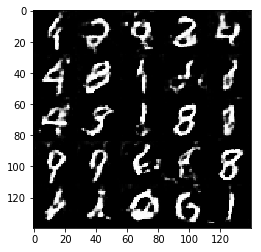

Epoch 1/2... Discriminator Loss: 0.8413... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 0.7878... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 1.7585
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 2.4017
Epoch 1/2... Discriminator Loss: 1.8457... Generator Loss: 0.2498
Epoch 1/2... Discriminator Loss: 2.8795... Generator Loss: 4.1917
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 1.6307
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.8123
Epoch 1/2.

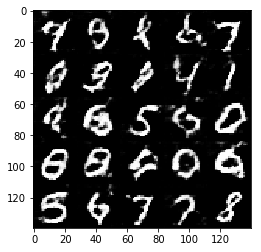

Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.5664
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 2.1486
Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.3176
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 2.8898
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 1.0070... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 2.1548... Generator Loss: 3.4291
Epoch 2/2... Discriminator Loss: 1.8436... Generator Loss: 0.2392
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 1.2133
Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 2.1115
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 0.9871
Epoch 2/2.

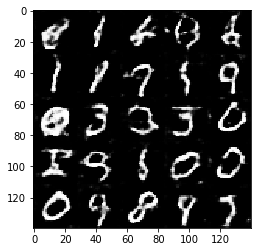

Epoch 2/2... Discriminator Loss: 1.5664... Generator Loss: 0.4152
Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 2.6792
Epoch 2/2... Discriminator Loss: 2.0350... Generator Loss: 0.2150
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 2.1482
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 1.7988
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.1142
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.1079... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.1263
Epoch 2/2.

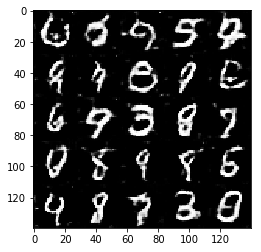

Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.7990
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 1.7788
Epoch 2/2... Discriminator Loss: 1.5568... Generator Loss: 0.3266
Epoch 2/2... Discriminator Loss: 2.5124... Generator Loss: 4.4034
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.9636
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.5880
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 1.7269
Epoch 2/2.

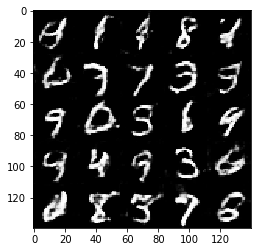

Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 2.1858
Epoch 2/2... Discriminator Loss: 1.5116... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.6428
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 0.9862
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.6696
Epoch 2/2.

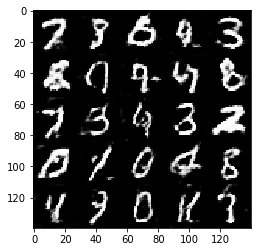

Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 0.9566
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 1.4916
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 2.5663
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.0341... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.7775
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.5681
Epoch 2/2.

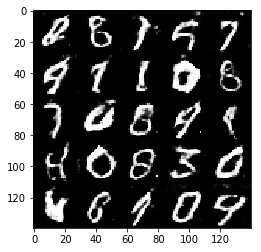

Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 2.2638
Epoch 2/2... Discriminator Loss: 2.5115... Generator Loss: 0.1523
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 2.6851
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.6624... Generator Loss: 0.3190
Epoch 2/2... Discriminator Loss: 1.7294... Generator Loss: 1.6115
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.5981
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 1.8478
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.4228
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 2.2514
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.4875
Epoch 2/2.

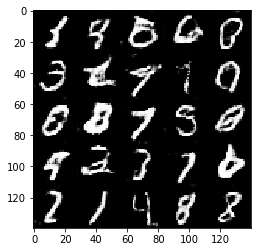

Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.4903
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.1281... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.1532
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 0.9348
Epoch 2/2... Discriminator Loss: 2.5058... Generator Loss: 0.1361
Epoch 2/2... Discriminator Loss: 1.8420... Generator Loss: 3.4650
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 1.3750
Epoch 2/2.

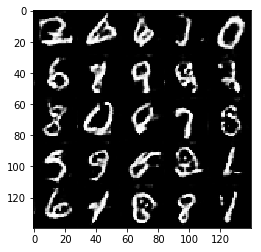

Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.4594
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 2.1825
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.4207
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 2.0854
Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 0.3703
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.7547
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.5237
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 0.6092
Epoch 2/2.

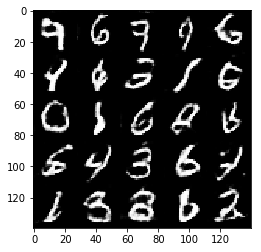

Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.5714
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.8557
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.8163... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 2.2241
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.0638
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 0.3815
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.9264
Epoch 2/2.

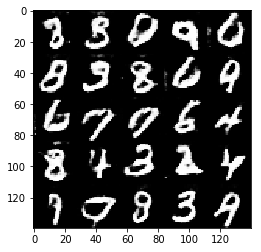

Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 2.0420
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 1.3884
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.7941
Epoch 2/2... Discriminator Loss: 2.3767... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 1.5528... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 2.1926
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 1.3157
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 2.0378
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.1917
Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.3310
Epoch 2/2.

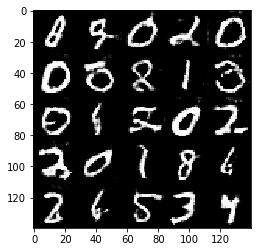

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 15.6470... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 3.7631... Generator Loss: 14.7864
Epoch 1/1... Discriminator Loss: 14.2372... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 0.3086... Generator Loss: 7.1124
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 3.1786
Epoch 1/1... Discriminator Loss: 19.3873... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 2.1525... Generator Loss: 2.4735
Epoch 1/1... Discriminator Loss: 0.2086... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 0.1006... Generator Loss: 3.5308
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 0.1504... Generator Loss: 4.1274
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.3186... Generator Loss: 6.0924
Epoch 1/1... Discriminator Loss: 2.3598... Generator Loss: 0.1696
Epoch 

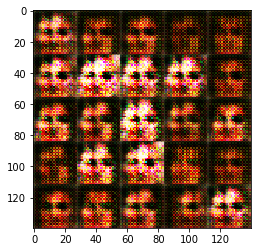

Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 2.5318
Epoch 1/1... Discriminator Loss: 0.2382... Generator Loss: 2.5352
Epoch 1/1... Discriminator Loss: 0.1460... Generator Loss: 3.7676
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 3.2736
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 1.8547
Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 3.2127
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 7.0060
Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 10.1220
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 4.0510
Epoch 1/1... Discriminator Loss: 2.0162... Generator Loss: 0.2077
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 5.7744
Epoch 1/1... Discriminator Loss: 0.2118... Generator Loss: 3.7664
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 1.4259
Epoch 1/1

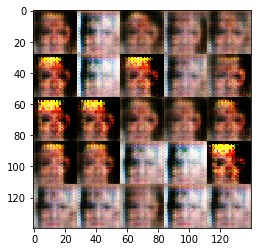

Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 2.0722
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.2155... Generator Loss: 3.3058
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 3.7328
Epoch 1/1... Discriminator Loss: 2.5283... Generator Loss: 0.0903
Epoch 1/1... Discriminator Loss: 5.0077... Generator Loss: 7.8588
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.3432
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 1.5594
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.4743
Epoch 1/1.

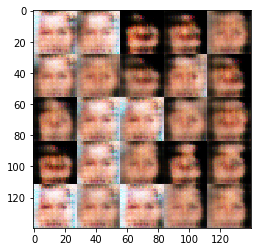

Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.8643
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 3.1676
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 1.3203
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 2.0221
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 2.2843... Generator Loss: 2.8473
Epoch 1/1... Discriminator Loss: 2.0700... Generator Loss: 0.2435
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 2.9056
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.7330
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.1167
Epoch 1/1.

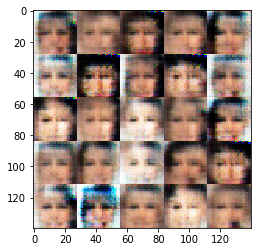

Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.9730... Generator Loss: 2.4495
Epoch 1/1... Discriminator Loss: 2.5487... Generator Loss: 0.1509
Epoch 1/1... Discriminator Loss: 1.7365... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7207
Epoch 1/1.

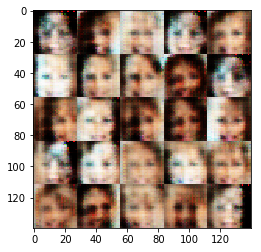

Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.9884
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 1.7835
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 1.9765
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 2.1844
Epoch 1/1.

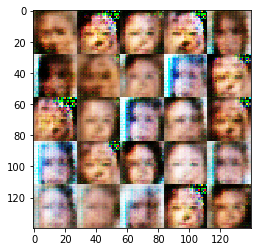

Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.8558
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 2.8185
Epoch 1/1... Discriminator Loss: 1.7100... Generator Loss: 0.3157
Epoch 1/1... Discriminator Loss: 3.3252... Generator Loss: 5.2552
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.7212
Epoch 1/1.

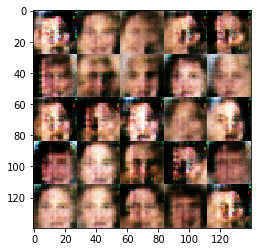

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 2.5329
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 2.2276
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 2.1478... Generator Loss: 3.2601
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 1.9058
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.0547
Epoch 1/1.

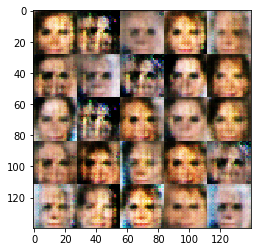

Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 3.2236... Generator Loss: 5.2871
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 1.7047... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 2.6716
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.7001
Epoch 1/1.

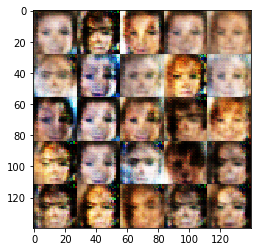

Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.6559
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 3.0024
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 2.1728
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 2.4670... Generator Loss: 3.2943
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.1287
Epoch 1/1.

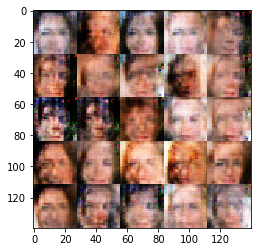

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 1.4413
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 2.1248
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 2.4380
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.8742
Epoch 1/1.

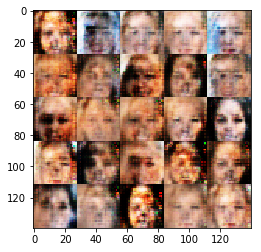

Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 2.3062
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 1.7902
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 2.2292... Generator Loss: 0.1655
Epoch 1/1... Discriminator Loss: 3.0712... Generator Loss: 4.0188
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.3051
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9139
Epoch 1/1.

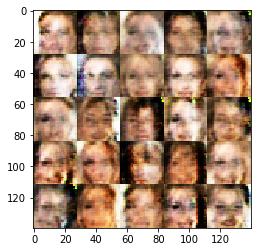

Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 2.1145
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 2.8652
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 2.6774
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 2.0613
Epoch 1/1.

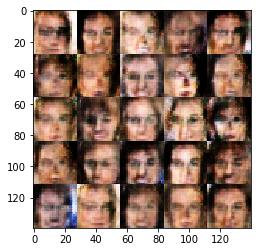

Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 2.8172
Epoch 1/1... Discriminator Loss: 1.9610... Generator Loss: 0.2232
Epoch 1/1... Discriminator Loss: 2.6199... Generator Loss: 3.3433
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.9228
Epoch 1/1.

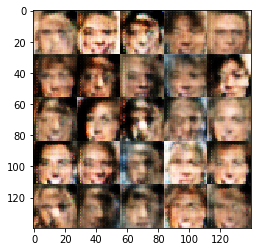

Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.3036
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.8975
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.7075
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6477
Epoch 1/1.

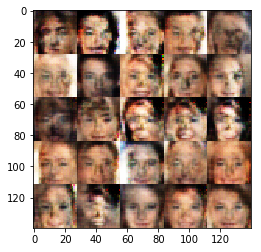

Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.9160
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 1.4619
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 2.1293
Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.5782
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.7547
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.3416
Epoch 1/1.

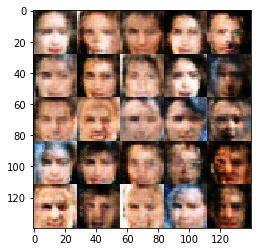

Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.6756
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.6874
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.6788
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.5566
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 2.3641
Epoch 1/1.

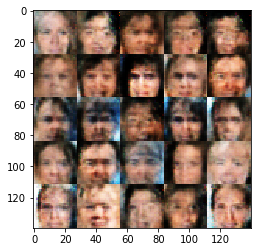

Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 2.8910
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 2.2256
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.5702
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.9625
Epoch 1/1.

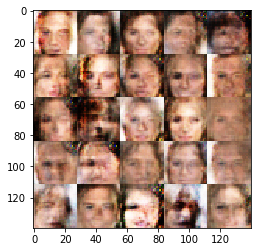

Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 1.9589
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 1.6597... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.4850
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.8554
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.2227
Epoch 1/1.

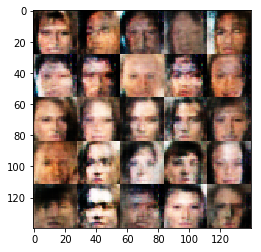

Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.4829
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 2.5150
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.5945
Epoch 1/1.

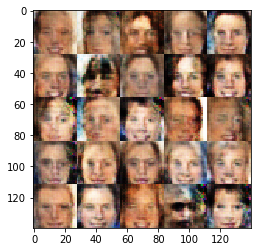

Epoch 1/1... Discriminator Loss: 1.8882... Generator Loss: 2.3728
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.7743
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 2.1346
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.2986
Epoch 1/1.

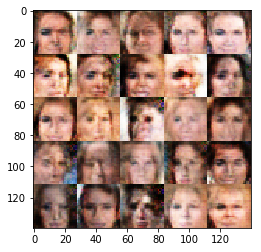

Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.7960
Epoch 1/1.

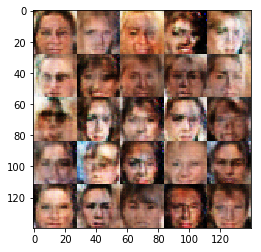

Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.9168
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7992
Epoch 1/1.

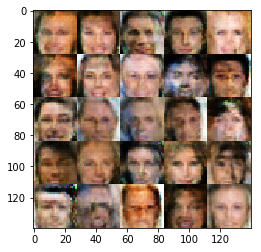

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 2.1357
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.7171
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 1.6688
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.9368... Generator Loss: 0.2116
Epoch 1/1... Discriminator Loss: 2.3577... Generator Loss: 3.5665
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.5856
Epoch 1/1.

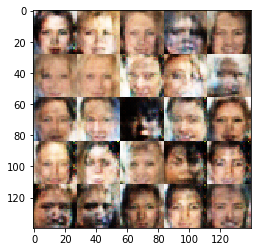

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.4424
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.6661
Epoch 1/1.

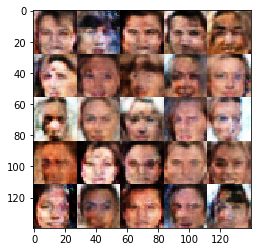

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.9202
Epoch 1/1.

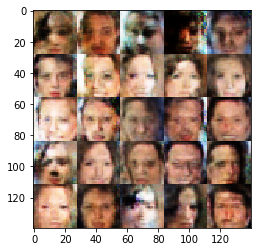

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.7690
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 1.9660
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.4972
Epoch 1/1.

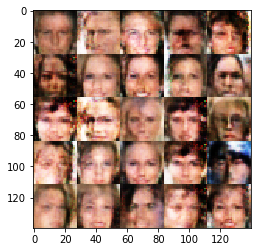

Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.0468
Epoch 1/1.

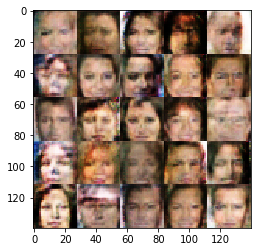

Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 2.8563
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.4209
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 2.8331
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 3.0623
Epoch 1/1.

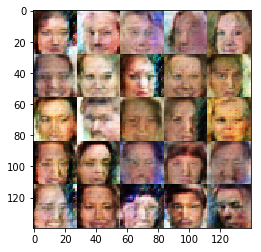

Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 3.2839
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 2.1753
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 1.9706
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 2.0066
Epoch 1/1.

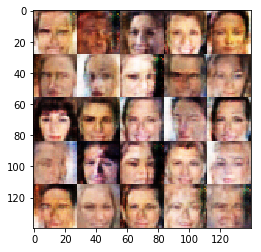

Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 2.5791... Generator Loss: 2.4138
Epoch 1/1... Discriminator Loss: 1.8731... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 2.0194... Generator Loss: 2.6680
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.7362
Epoch 1/1.

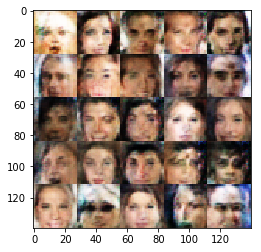

Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 1.7235
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 0.9413
Epoch 1/1.

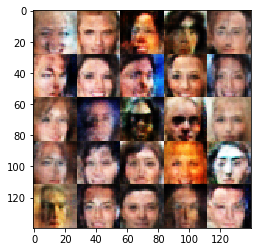

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.